# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

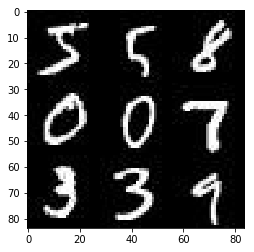

In [2]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

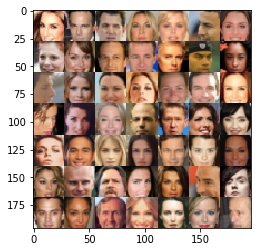

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


C:\Users\Ehsan\Anaconda3\envs\face-generation\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    Real_Input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    Z_Data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    LR = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    return Real_Input, Z_Data, LR

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        rel1 = tf.maximum(alpha*x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(rel1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        rel2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(rel2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        rel3 = tf.maximum(alpha*bn3, bn3)
        # 7x7x256
        
        #Flatten it
        flat = tf.reshape(rel3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    keep_prob = 0.5
    with tf.variable_scope('generator', reuse=not is_train):
          
        #Fully connected layer
        x = tf.layers.dense(z, 4*4*1024, activation = None)
        x = tf.reshape(x, (-1, 4, 4, 1024))
        x = tf.layers.batch_normalization(x, training=is_train)
#        x = tf.maximum(alpha*x, x)
        # swish activation
        x = tf.sigmoid(x)*x
#        x = tf.nn.relu(x)
        # 4x4x1024
        
        x = tf.layers.conv2d_transpose(x, 512, 5, strides=2, padding='same', use_bias= False,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
#        x = tf.maximum(alpha*x, x)
        # swish activation
        x = tf.sigmoid(x)*x
#        x = tf.nn.relu(x)
        # 8x8x512
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same', use_bias= False,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
#        x = tf.maximum(alpha*x, x)
        # swish activation
        x = tf.sigmoid(x)*x
#        x = tf.nn.relu(x)

        # 16x16x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same', use_bias= False,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
#        x = tf.maximum(alpha*x, x)
        # swish activation
        x = tf.sigmoid(x)*x
#        x = tf.nn.relu(x)
        # 32x32x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=1, padding='same', use_bias= False,
                                      kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
#        x = tf.maximum(alpha*x, x)
        # swish activation
        x = tf.sigmoid(x)*x
#        x = tf.nn.relu(x)
        # 32x32x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
#        logits = tf.contrib.layers.dropout(logits, keep_prob, is_training=is_train)
        logits = tf.image.resize_images(logits, (28, 28))
        output = tf.tanh(logits)
        
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # label Smoothing factor 
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    # d-loss-real with smoothing factor
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, alpha, get_batches, data_shape, data_image_mode):
   
    # model
    input_real, input_z, LR = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    steps = 0
    print_every = 50
    
    with tf.Session() as sess:
#        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
#        sess.run(init_op)
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps +=1
                
                #sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images*2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, LR: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, LR: learning_rate})
    
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                    
                if steps % 500 == 0:
                    fig, ax = pyplot.subplots()
                    losses_plot = np.array(losses)
                    pyplot.plot(losses_plot.T[0], label='Discriminator', alpha=0.5)
                    pyplot.plot(losses_plot.T[1], label='Generator', alpha=0.5)
                    pyplot.title("Training Losses")
                    pyplot.legend()
                    pyplot.show()
                    
                    show_generator_output(sess, 25,input_z,data_shape[3],data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

batch_size:  16 -- z_dim:  100 -- LR:  0.0001 -- beta1:  0.5 -- alpha:  0.2
swish activation -- Generator - Dropout 0.5
Epoch 1/2... Discriminator Loss: 1.7237... Generator Loss: 0.4403
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.9223
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 0.5742
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 1.3978
Epoch 1/2... Discriminator Loss: 1.1538... Generator Loss: 0.8498
Epoch 1/2... Discriminator Loss: 1.6162... Generator Loss: 0.3729
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.5992
Epoch 1/2... Discriminator Loss: 1.3433... Generator Loss: 0.6339


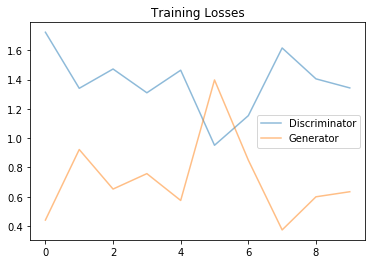

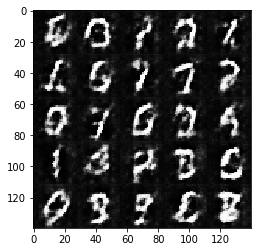

Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.5321
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 1.2420
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.4914
Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 1.1751... Generator Loss: 1.1603
Epoch 1/2... Discriminator Loss: 1.8299... Generator Loss: 0.3131
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 0.6249
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 1.0111


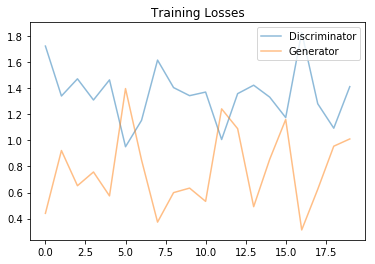

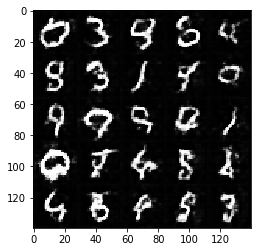

Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.5920
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.5654
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 1.5239
Epoch 1/2... Discriminator Loss: 1.1736... Generator Loss: 0.8541
Epoch 1/2... Discriminator Loss: 1.1416... Generator Loss: 1.1219
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 0.7483
Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 0.8382
Epoch 1/2... Discriminator Loss: 1.5229... Generator Loss: 0.6005
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 0.7285


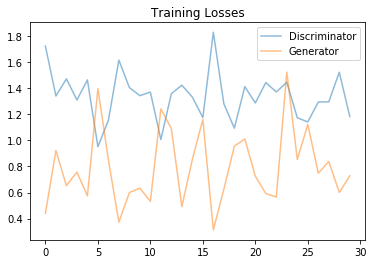

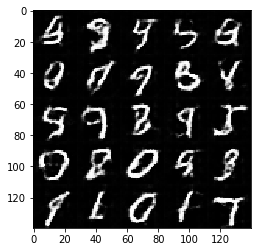

Epoch 1/2... Discriminator Loss: 1.6588... Generator Loss: 0.7053
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.9180
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.5385
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.8361
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.4613
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.8481
Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 0.8496
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 0.7100
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 0.6515


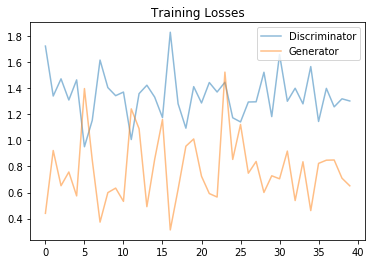

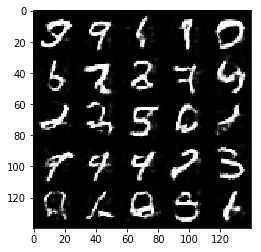

Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 0.7188
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 1.0866
Epoch 1/2... Discriminator Loss: 1.1037... Generator Loss: 1.1623
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.9385
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.8922
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 0.9089
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 1.2323
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.8498
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.9434


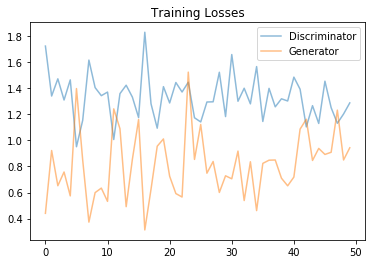

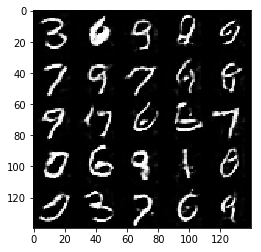

Epoch 1/2... Discriminator Loss: 1.4158... Generator Loss: 0.7727
Epoch 1/2... Discriminator Loss: 1.4623... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 0.8966
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.6770
Epoch 1/2... Discriminator Loss: 1.5357... Generator Loss: 0.6722
Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.8116
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.9125


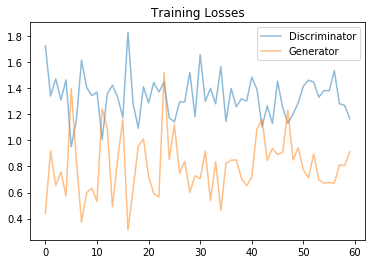

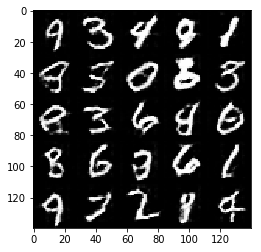

Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.7736
Epoch 1/2... Discriminator Loss: 1.5222... Generator Loss: 0.5904
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.6641
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 0.8165
Epoch 1/2... Discriminator Loss: 1.7233... Generator Loss: 0.7403
Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 1.1435
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.6261
Epoch 1/2... Discriminator Loss: 1.5563... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 1.1381


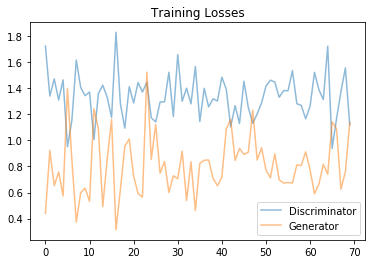

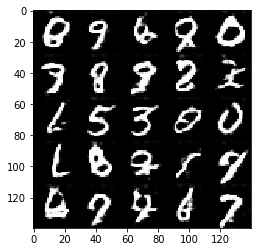

Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.7739
Epoch 1/2... Discriminator Loss: 1.4922... Generator Loss: 0.6400
Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 0.8327
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.8590
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.6617
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 0.7239
Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 1.0360


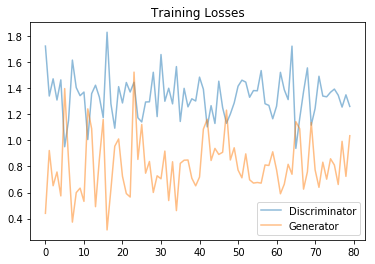

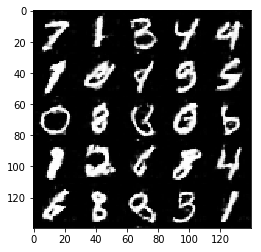

Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.6426
Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.4308... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.4606... Generator Loss: 0.6842
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 1.5781... Generator Loss: 0.5567
Epoch 2/2... Discriminator Loss: 1.4505... Generator Loss: 0.5801
Epoch 2/2... Discriminator Loss: 1.5023... Generator Loss: 0.5469
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.8432


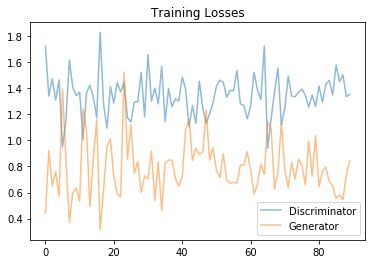

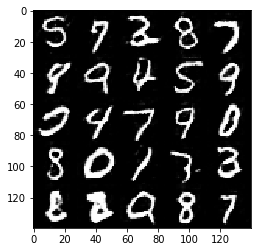

Epoch 2/2... Discriminator Loss: 1.4126... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.5898... Generator Loss: 0.5161
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 1.0650
Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.7755
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 1.0719
Epoch 2/2... Discriminator Loss: 1.4696... Generator Loss: 0.6935
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.8215
Epoch 2/2... Discriminator Loss: 1.2741... Generator Loss: 1.0009


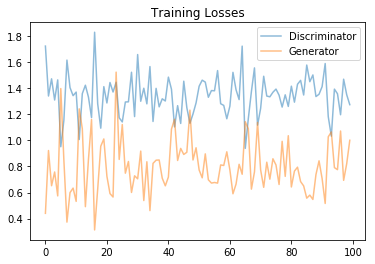

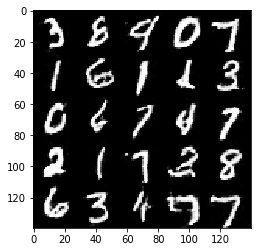

Epoch 2/2... Discriminator Loss: 1.3207... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 1.4470... Generator Loss: 0.5726
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.9975
Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.6794
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.8985
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.7888
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 1.6408... Generator Loss: 0.7238


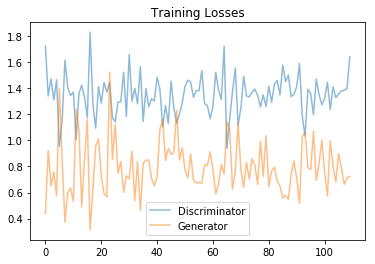

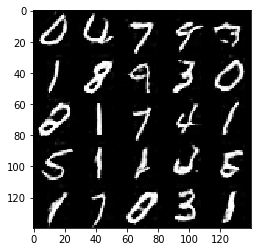

Epoch 2/2... Discriminator Loss: 1.3685... Generator Loss: 0.7178
Epoch 2/2... Discriminator Loss: 1.4360... Generator Loss: 0.7296
Epoch 2/2... Discriminator Loss: 1.2528... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 0.8745
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.9822
Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.6351
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 0.9376
Epoch 2/2... Discriminator Loss: 1.4484... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 0.8125


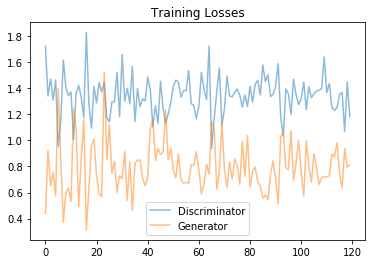

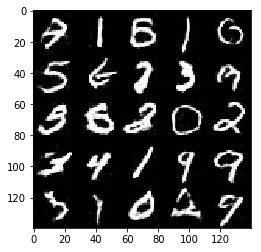

Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 0.9190
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 1.1538
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 1.1456
Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.7986
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.7249
Epoch 2/2... Discriminator Loss: 1.5369... Generator Loss: 0.6182
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 1.3160... Generator Loss: 0.6885


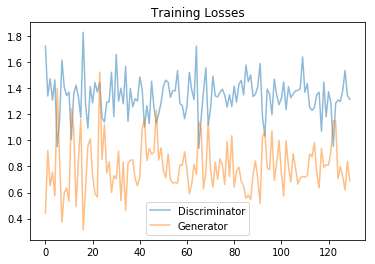

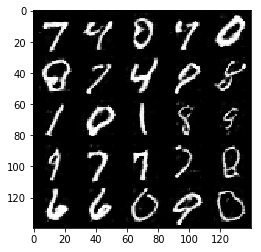

Epoch 2/2... Discriminator Loss: 1.4434... Generator Loss: 0.7416
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.7390
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.6598
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.8168
Epoch 2/2... Discriminator Loss: 1.4600... Generator Loss: 0.5948
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.7646
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.7192
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.7161
Epoch 2/2... Discriminator Loss: 1.2933... Generator Loss: 0.7744


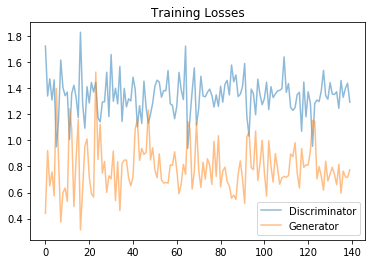

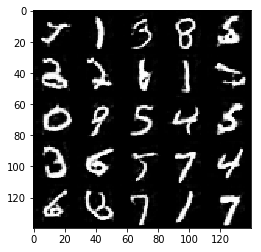

Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 0.9815
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 1.0214
Epoch 2/2... Discriminator Loss: 1.1533... Generator Loss: 0.8640
Epoch 2/2... Discriminator Loss: 1.2962... Generator Loss: 0.8637
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.7837
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.7414
Epoch 2/2... Discriminator Loss: 1.4457... Generator Loss: 0.7067
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.8447
Epoch 2/2... Discriminator Loss: 1.3703... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 0.9831


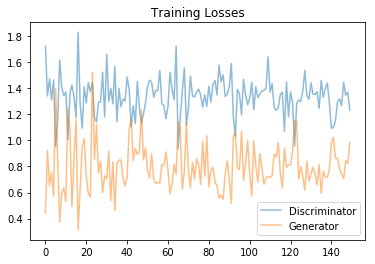

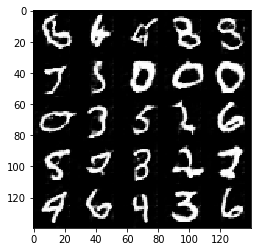

In [12]:
batch_size = 16
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
alpha = 0.2
# smooth = 0.1
# keep_prob = 0.5
print('batch_size: ', batch_size, '-- z_dim: ', z_dim, '-- LR: ', learning_rate, '-- beta1: ', beta1, '-- alpha: ', alpha)
print('swish activation', '--', 'Generator - Dropout 0.5')

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, alpha, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1041... Generator Loss: 0.3146
Epoch 1/1... Discriminator Loss: 2.3750... Generator Loss: 0.2719
Epoch 1/1... Discriminator Loss: 2.1639... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.8906


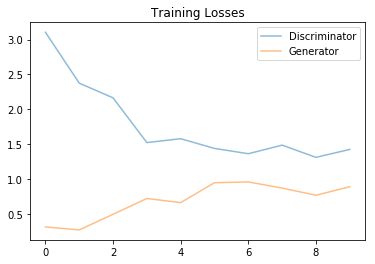

Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.5986... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7290


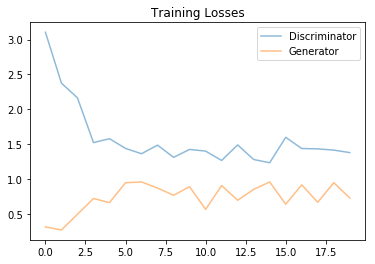

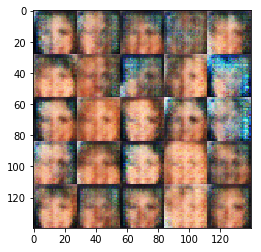

Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.8046


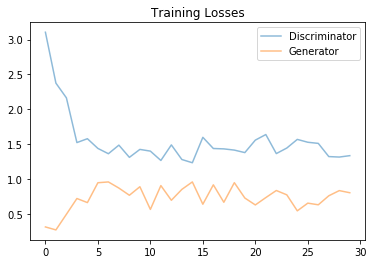

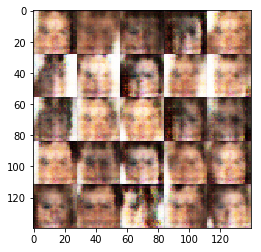

Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7410


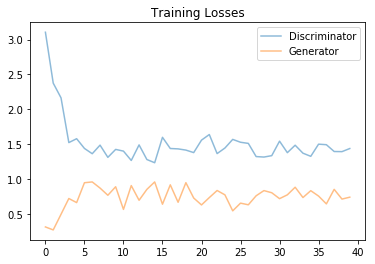

Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.8210


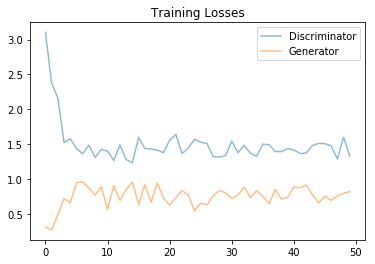

Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7032


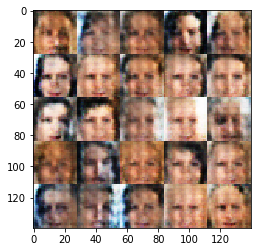

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.6443... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.6849


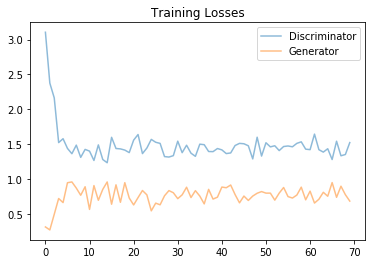

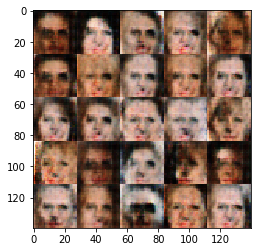

Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8521


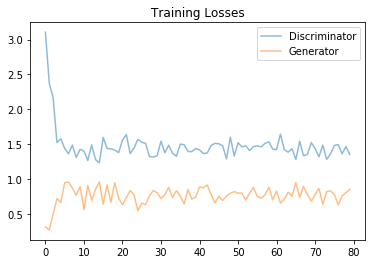

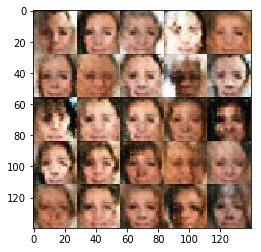

Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.7619


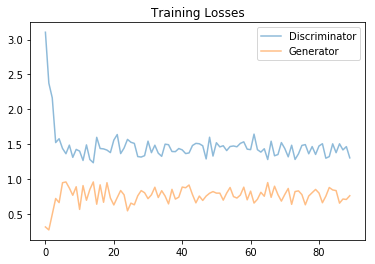

Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.8278


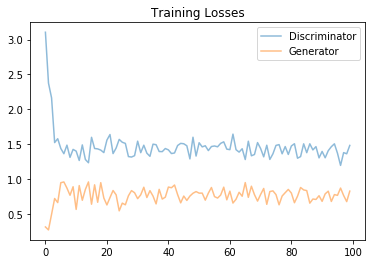

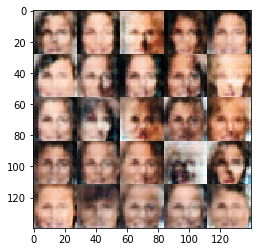

Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.8640


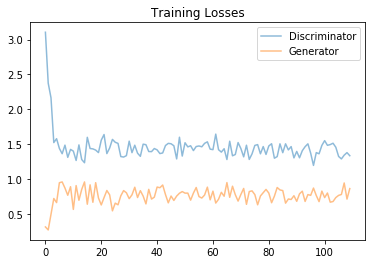

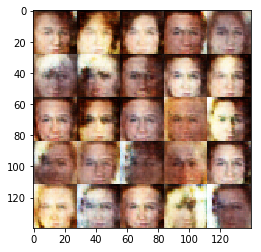

Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.7774


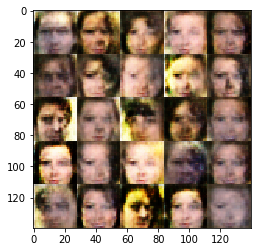

Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.6763


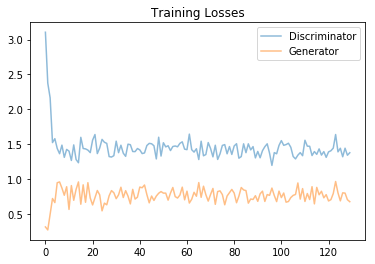

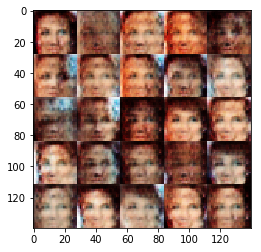

Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7901


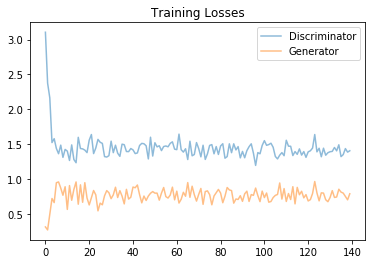

Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.6139... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7771


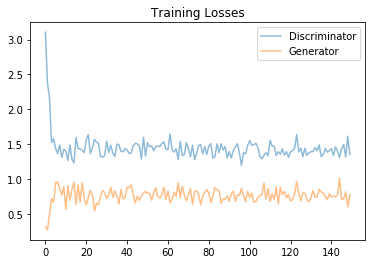

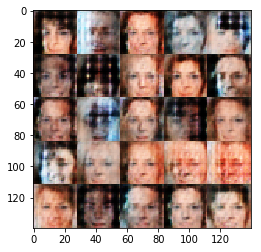

Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7779


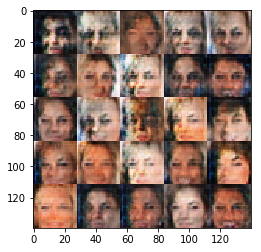

Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8697


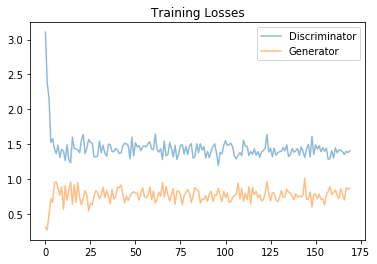

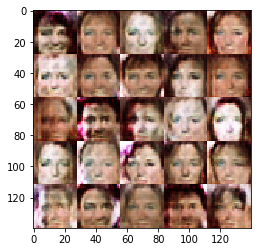

Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6640


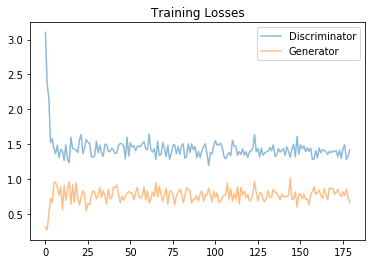

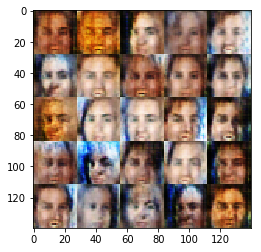

Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7939


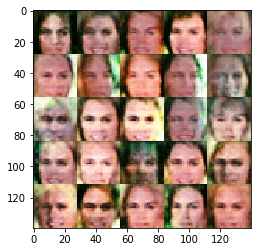

Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.8624


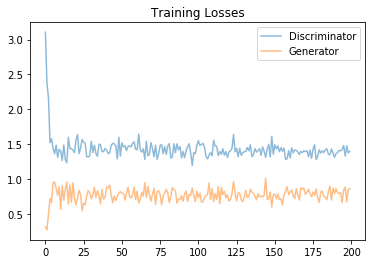

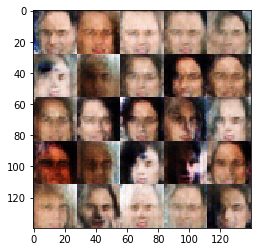

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7916


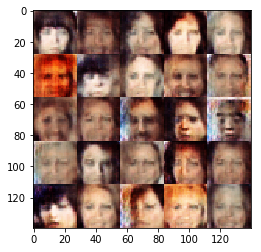

Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.7921


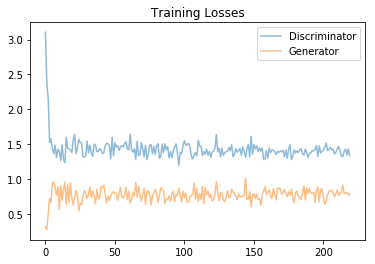

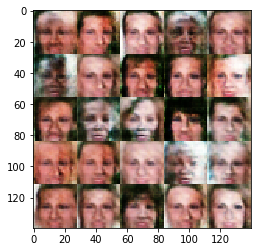

Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7313


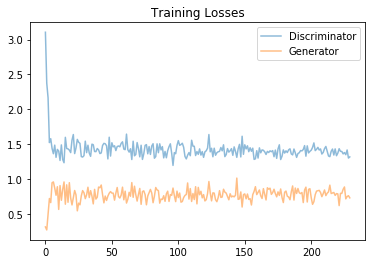

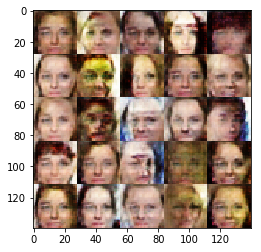

Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7945


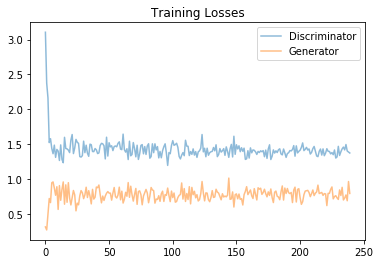

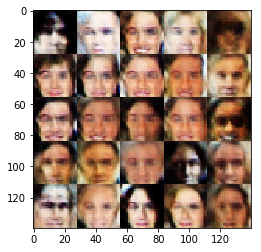

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7118


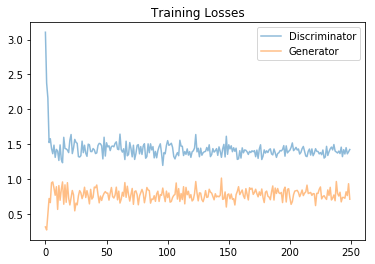

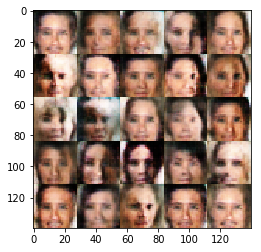

Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6688


In [13]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, alpha, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.